# Build a Milvus Powered Text-Image Search Engine in Minutes

This notebook illustrates how to build an text-image search engine from scratch using [Milvus](https://milvus.io/). Milvus is the most advanced open-source vector database built for AI applications and supports nearest neighbor embedding search across tens of millions of entries. We'll go through text-image search procedures and evaluate the performance. Moreover, we managed to make the core functionality as simple as a dozen lines of code, with which you can start hacking your own image search engine.

## Preparation
### Install Dependencies
First we need to install dependencies such as towhee, gradio and opencv-python.

In [1]:
! python -m pip install -q towhee gradio opencv-python

### Prepare the data

The dataset used in this demo is a subset of the ImageNet dataset (100 classes, 10 images for each class), and the dataset is available via [Github](https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip). 

The dataset is organized as follows:
- **train**: directory of candidate images;
- **test**: directory of test images;
- **reverse_image_search.csv**: a csv file containing an ***id***, ***path***, and ***label*** for each image;

Let's take a quick look:

In [2]:
! curl -L https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip -O
! unzip -q -o reverse_image_search.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  119M  100  119M    0     0  8071k      0  0:00:15  0:00:15 --:--:-- 10.6M


In [3]:
import pandas as pd

df = pd.read_csv('reverse_image_search.csv')
df.head()

,id,path,label
0,0,./train/brain_coral/n01917289_1783.JPEG,brain_coral
1,1,./train/brain_coral/n01917289_4317.JPEG,brain_coral
2,2,./train/brain_coral/n01917289_765.JPEG,brain_coral
3,3,./train/brain_coral/n01917289_1079.JPEG,brain_coral
4,4,./train/brain_coral/n01917289_2484.JPEG,brain_coral


To use the dataset for text-image search, let's first define some helper function:

- **read_images(results)**: read images by image IDs;

In [4]:
import cv2
from towhee.types.image import Image

id_img = df.set_index('id')['path'].to_dict()
def read_images(results):
    imgs = []
    for re in results:
        path = id_img[re.id]
        imgs.append(Image(cv2.imread(path), 'BGR'))
    return imgs


### Create a Milvus Collection

Before getting started, please make sure that you have started a [Milvus service](https://milvus.io/docs/install_standalone-docker.md). This notebook uses [milvus 2.2.10](https://milvus.io/docs/v2.2.x/install_standalone-docker.md) and [pymilvus 2.2.11](https://milvus.io/docs/release_notes.md#2210).

In [ ]:
! python -m pip install -q pymilvus==2.2.11

Let's first create a `text_image_search` collection that uses the [L2 distance metric](https://milvus.io/docs/metric.md#Euclidean-distance-L2) and an [IVF_FLAT index](https://milvus.io/docs/index.md#IVF_FLAT).

In [5]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

def create_milvus_collection(collection_name, dim):
    connections.connect(host='127.0.0.1', port='19530')
    
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
    FieldSchema(name='id', dtype=DataType.INT64, descrition='ids', is_primary=True, auto_id=False),
    FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, descrition='embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='text image search')
    collection = Collection(name=collection_name, schema=schema)

    # create IVF_FLAT index for collection.
    index_params = {
        'metric_type':'L2',
        'index_type':"IVF_FLAT",
        'params':{"nlist":512}
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    return collection

collection = create_milvus_collection('text_image_search', 512)

## Text Image Search

In this section, we'll show how to build our text-image search engine using Milvus. The basic idea behind our text-image search is the extract embeddings from images and texts using a deep neural network and compare the embeddings with those stored in Milvus.

We use [Towhee](https://towhee.io/), a machine learning framework that allows for creating data processing pipelines, and it also provides predefined operators which implement insert and query operation in Milvus.

<img src="./workflow.png" width = "60%" height = "60%" align=center />

### Generate image and text embeddings with CLIP


This operator extracts features for image or text with [CLIP](https://openai.com/blog/clip/) which can generate embeddings for text and image by jointly training an image encoder and text encoder to maximize the cosine similarity.

In [6]:
from towhee import ops, pipe, DataCollection
import numpy as np

2023-06-12 14:54:53,081 - 140406106779840 - connectionpool.py-connectionpool:1003 - DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2023-06-12 14:54:54,529 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/config.json HTTP/1.1" 200 0
2023-06-12 14:54:56,725 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/vocab.json HTTP/1.1" 200 0
2023-06-12 14:54:57,253 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2023-06-12 14:54:57,544 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2023-06-12 14:54:57,626 - 140397301311232 - node.py-node:

img,vec
,"[0.037240546, -0.065988705, -0.010860455, ...] shape=(512,)"

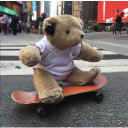

<Figure size 128x128 with 0 Axes>

In [7]:
p = (
    pipe.input('path')
    .map('path', 'img', ops.image_decode.cv2('rgb'))
    .map('img', 'vec', ops.image_text_embedding.clip(model_name='clip_vit_base_patch16', modality='image'))
    .map('vec', 'vec', lambda x: x / np.linalg.norm(x))
    .output('img', 'vec')
)

DataCollection(p('./teddy.png')).show()


In [8]:
p2 = (
    pipe.input('text')
    .map('text', 'vec', ops.image_text_embedding.clip(model_name='clip_vit_base_patch16', modality='text'))
    .map('vec', 'vec', lambda x: x / np.linalg.norm(x))
    .output('text', 'vec')
)

DataCollection(p2("A teddybear on a skateboard in Times Square.")).show()

2023-06-12 14:55:03,300 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/config.json HTTP/1.1" 200 0
2023-06-12 14:55:05,445 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/vocab.json HTTP/1.1" 200 0
2023-06-12 14:55:05,830 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2023-06-12 14:55:06,123 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2023-06-12 14:55:06,205 - 140396121286400 - node.py-node:167 - INFO: Begin to run Node-_input
2023-06-12 14:55:06,207 - 140396121286400 - node.py-node:167 - INFO: Begin to run Node-image-text-embedding/

text,vec
A teddybear on a skateboard in Times Square.,"[-0.0086854, 0.02717687, -0.0007425508, ...] shape=(512,)"


Here is detailed explanation of the code:

- `map('path', 'img', ops.image_decode.cv2_rgb('rgb'))`: for each row from the data, read and decode the image at `path` and put the pixel data into column `img`;

- `map('img', 'vec', ops.image_text_embedding.clip(model_name='clip_vit_base_patch16',modality='image'/'text')`: extract image or text embedding feature with `ops.image_text_embedding.clip`, an operator from the [Towhee hub](https://towhee.io/image-text-embedding/clip) . This operator supports seveal models including `clip_vit_base_patch16`,`clip_vit_base_patch32`,`clip_vit_large_patch14`,`clip_vit_large_patch14_336`,etc.

### Load Image Embeddings into Milvus

We first extract embeddings from images with `clip_vit_base_patch16` model and insert the embeddings into Milvus for indexing. Towhee provides a [method-chaining style API](https://towhee.readthedocs.io/en/main/index.html) so that users can assemble a data processing pipeline with operators. 

In [18]:
%%time
collection = create_milvus_collection('text_image_search', 512)

def read_csv(csv_path, encoding='utf-8-sig'):
    import csv
    with open(csv_path, 'r', encoding=encoding) as f:
        data = csv.DictReader(f)
        for line in data:
            yield int(line['id']), line['path']

p3 = (
    pipe.input('csv_file')
    .flat_map('csv_file', ('id', 'path'), read_csv)
    .map('path', 'img', ops.image_decode.cv2('rgb'))
    .map('img', 'vec', ops.image_text_embedding.clip(model_name='clip_vit_base_patch16', modality='image', device=0))
    .map('vec', 'vec', lambda x: x / np.linalg.norm(x))
    .map(('id', 'vec'), (), ops.ann_insert.milvus_client(host='127.0.0.1', port='19530', collection_name='text_image_search'))
    .output()
)

ret = p3('reverse_image_search.csv')


2023-06-12 16:16:47,531 - 140406106779840 - connectionpool.py-connectionpool:273 - DEBUG: Resetting dropped connection: huggingface.co
2023-06-12 16:16:48,943 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/config.json HTTP/1.1" 200 0
2023-06-12 16:16:51,909 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/vocab.json HTTP/1.1" 200 0
2023-06-12 16:16:52,316 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2023-06-12 16:16:52,605 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2023-06-12 16:16:52,733 - 140381920413440 - node.py-node:167 - INFO

CPU times: user 1min 5s, sys: 46.7 s, total: 1min 52s
Wall time: 28.6 s


In [11]:
collection.load()

In [12]:
print('Total number of inserted data is {}.'.format(collection.num_entities))

Total number of inserted data is 0.


### Query Matched Images from Milvus

Now that embeddings for candidate images have been inserted into Milvus, we can query across it for nearest neighbors. Again, we use Towhee to load the input Text, compute an embedding vector, and use the vector as a query for Milvus. Because Milvus only outputs image IDs and distance values, we provide a `read_images` function to get the original image based on IDs and display.

2023-06-12 14:56:15,172 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/config.json HTTP/1.1" 200 0
2023-06-12 14:56:17,239 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/vocab.json HTTP/1.1" 200 0
2023-06-12 14:56:17,616 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2023-06-12 14:56:17,946 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2023-06-12 14:56:18,058 - 140385418467072 - node.py-node:167 - INFO: Begin to run Node-_input
2023-06-12 14:56:18,059 - 140385391195904 - node.py-node:167 - INFO: Begin to run Node-image-text-embedding/

text,images
A white dog,

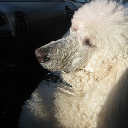
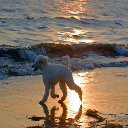
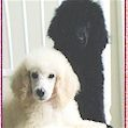
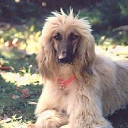
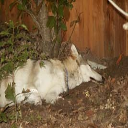

2023-06-12 14:56:18,246 - 140393312151296 - node.py-node:167 - INFO: Begin to run Node-_input
2023-06-12 14:56:18,247 - 140385391195904 - node.py-node:167 - INFO: Begin to run Node-image-text-embedding/clip-0
2023-06-12 14:56:18,247 - 140385382803200 - node.py-node:167 - INFO: Begin to run Node-lambda-1
2023-06-12 14:56:18,247 - 140384248522496 - node.py-node:167 - INFO: Begin to run Node-ann-search/milvus-client-2
2023-06-12 14:56:18,248 - 140385418467072 - node.py-node:167 - INFO: Begin to run Node-lambda-3
2023-06-12 14:56:18,248 - 140384240129792 - node.py-node:167 - INFO: Begin to run Node-read_image-4
2023-06-12 14:56:18,248 - 140383858194176 - node.py-node:167 - INFO: Begin to run Node-_output


text,images
A black dog,

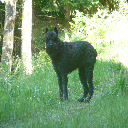
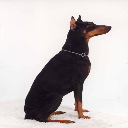
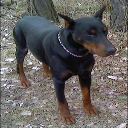
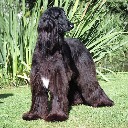
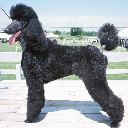

In [13]:
import pandas as pd
import cv2

def read_image(image_ids):
    df = pd.read_csv('reverse_image_search.csv')
    id_img = df.set_index('id')['path'].to_dict()
    imgs = []
    decode = ops.image_decode.cv2('rgb')
    for image_id in image_ids:
        path = id_img[image_id]
        imgs.append(decode(path))
    return imgs


p4 = (
    pipe.input('text')
    .map('text', 'vec', ops.image_text_embedding.clip(model_name='clip_vit_base_patch16', modality='text'))
    .map('vec', 'vec', lambda x: x / np.linalg.norm(x))
    .map('vec', 'result', ops.ann_search.milvus_client(host='127.0.0.1', port='19530', collection_name='text_image_search', limit=5))
    .map('result', 'image_ids', lambda x: [item[0] for item in x])
    .map('image_ids', 'images', read_image)
    .output('text', 'images')
)

DataCollection(p4("A white dog")).show()
DataCollection(p4("A black dog")).show()

## Release a Showcase

We've done an excellent job on the core functionality of our text-image search engine. Now it's time to build a showcase with interface. [Gradio](https://gradio.app/) is a great tool for building demos. With Gradio, we simply need to wrap the data processing pipeline via a `search_in_milvus` function:

In [20]:
search_pipeline = (
    pipe.input('text')
    .map('text', 'vec', ops.image_text_embedding.clip(model_name='clip_vit_base_patch16', modality='text'))
    .map('vec', 'vec', lambda x: x / np.linalg.norm(x))
    .map('vec', 'result', ops.ann_search.milvus_client(host='127.0.0.1', port='19530', collection_name='text_image_search', limit=5))
    .map('result', 'image_ids', lambda x: [item[0] for item in x])
    .output('image_ids')
)

def search(text):
    df = pd.read_csv('reverse_image_search.csv')
    id_img = df.set_index('id')['path'].to_dict()
    imgs = []
    image_ids = search_pipeline(text).to_list()[0][0]
    return [id_img[image_id] for image_id in image_ids]


2023-06-12 16:22:30,654 - 140406106779840 - connectionpool.py-connectionpool:273 - DEBUG: Resetting dropped connection: huggingface.co
2023-06-12 16:22:32,024 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/config.json HTTP/1.1" 200 0
2023-06-12 16:22:34,339 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/vocab.json HTTP/1.1" 200 0
2023-06-12 16:22:34,717 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2023-06-12 16:22:35,002 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch16/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


In [21]:
import gradio

interface = gradio.Interface(search, 
                             gradio.inputs.Textbox(lines=1),
                             [gradio.outputs.Image(type="filepath", label=None) for _ in range(5)]
                            )

interface.launch(inline=True, share=True)

2023-06-12 16:22:37,627 - 140392909498112 - connectionpool.py-connectionpool:1003 - DEBUG: Starting new HTTPS connection (1): api.gradio.app:443
2023-06-12 16:22:37,629 - 140406106779840 - connectionpool.py-connectionpool:1003 - DEBUG: Starting new HTTPS connection (1): api.gradio.app:443
2023-06-12 16:22:39,054 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://api.gradio.app:443 "GET /pkg-version HTTP/1.1" 200 21
2023-06-12 16:22:39,128 - 140402095003392 - selector_events.py-selector_events:54 - DEBUG: Using selector: EpollSelector
2023-06-12 16:22:39,134 - 140406106779840 - connectionpool.py-connectionpool:228 - DEBUG: Starting new HTTP connection (1): 127.0.0.1:7863
2023-06-12 16:22:39,138 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: http://127.0.0.1:7863 "GET /startup-events HTTP/1.1" 200 5
2023-06-12 16:22:39,143 - 140406106779840 - connectionpool.py-connectionpool:228 - DEBUG: Starting new HTTP connection (1): 127.0.0.1:7863
2023-06-12

Running on local URL:  http://127.0.0.1:7863


2023-06-12 16:22:42,604 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://api.gradio.app:443 "GET /v2/tunnel-request HTTP/1.1" 200 None
2023-06-12 16:22:44,331 - 140406106779840 - connectionpool.py-connectionpool:1003 - DEBUG: Starting new HTTPS connection (1): 0353404c1d46f8b38d.gradio.live:443


Running on public URL: https://0353404c1d46f8b38d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


2023-06-12 16:22:46,117 - 140406106779840 - connectionpool.py-connectionpool:456 - DEBUG: https://0353404c1d46f8b38d.gradio.live:443 "HEAD / HTTP/1.1" 200 0


2023-06-12 16:22:46,133 - 140403532490496 - connectionpool.py-connectionpool:1003 - DEBUG: Starting new HTTPS connection (1): api.gradio.app:443


2023-06-12 16:22:47,753 - 140403532490496 - connectionpool.py-connectionpool:456 - DEBUG: https://api.gradio.app:443 "POST /gradio-launched-telemetry/ HTTP/1.1" 200 None
